In [90]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from scipy import signal

# Setting up the 1D data and template

In [91]:
nside = 32

map_ = np.zeros(12*nside**2)
map_[1000] = 1
map_[10000] = 0.5

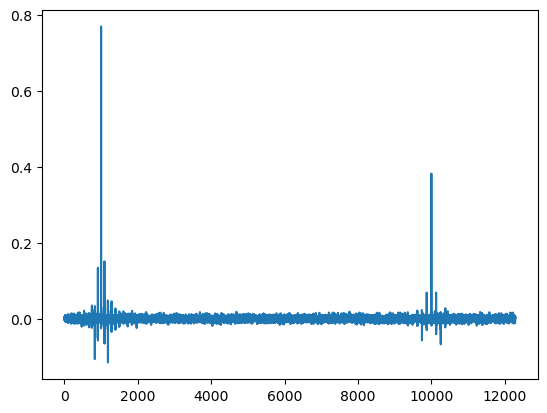

In [92]:
map_1d = hp.smoothing(map_) + 5e-3*np.random.randn(len(map_))
plt.plot(map_1d)

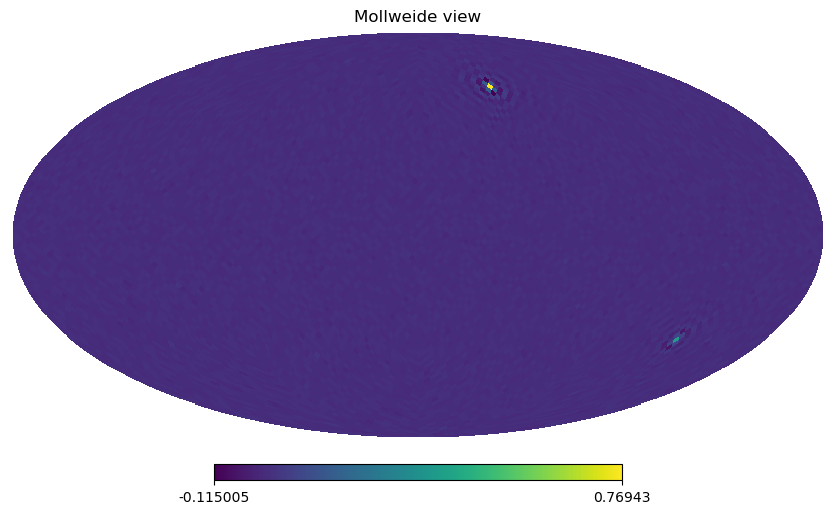

In [93]:
hp.mollview(map_1d)

In [94]:
template_ = np.zeros_like(map_1d)
template_[len(template_)//2] = 1
template_1d = hp.smoothing(template_)

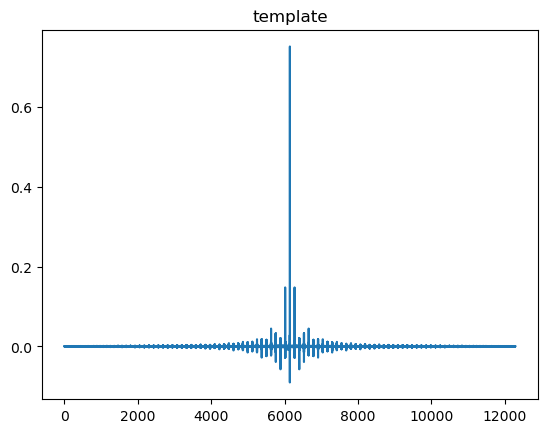

In [95]:
plt.plot(template_1d)
plt.title('template')
plt.show()

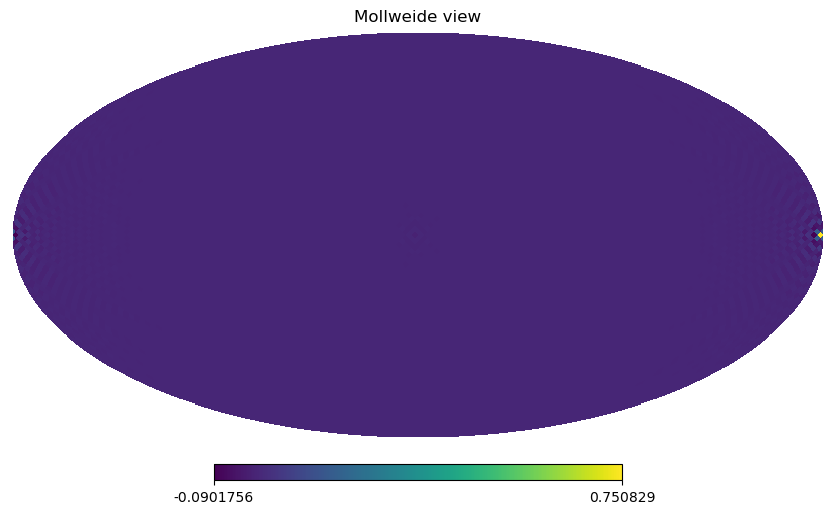

In [96]:
hp.mollview(template_1d)

# Looking at noise properties

In [97]:
def smooth_vector(vec, sig):
    n=len(vec)
    x=np.arange(n)
    x[n//2:]=x[n//2:]-n
    kernel=np.exp(-0.5*x**2/sig**2) #make a Gaussian kernel
    kernel=kernel/kernel.sum()
    vecft=np.fft.rfft(vec)
    kernelft=np.fft.rfft(kernel)
    vec_smooth=np.fft.irfft(vecft*kernelft) #convolve the data with the kernel
    return vec_smooth

In [98]:
Ninv_smoothing_sigma = 10
x = np.linspace(-np.pi/2,np.pi/2,len(map_1d))
win = signal.windows.tukey(len(x))
ps = np.abs(np.fft.fft(map_1d * win))**2
ps_smooth=smooth_vector(ps, Ninv_smoothing_sigma)
Ninv=1/ps_smooth

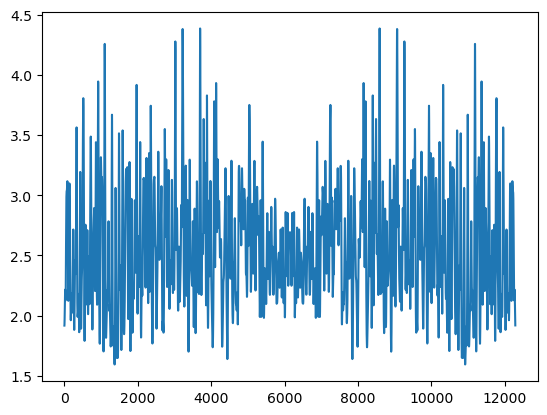

In [99]:
plt.plot(Ninv)

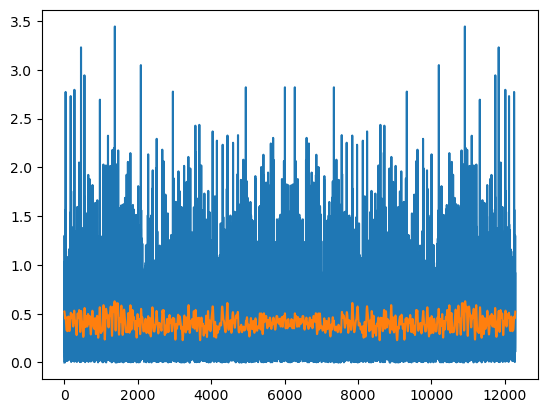

In [100]:
plt.plot(ps)
plt.plot(ps_smooth)

In [101]:
## Step 6: Preparing template for mf
template_ft = np.fft.fft(template_1d*win)
template_ft_white = template_ft * np.sqrt(Ninv)

## Step 6: Preparing data for mf
data_ft = np.fft.fft(map_1d*win)
data_ft_white = data_ft * np.sqrt(Ninv)

## Step 7: Computing matched filter
rhs = np.real(np.fft.ifft(data_ft_white * np.conj(template_ft_white)))
lhs = np.real(template_ft_white.T @ template_ft_white)
mf = np.fft.fftshift(rhs / lhs)

In [102]:
peaks, _ = signal.find_peaks(mf/np.max(mf), height=0.3)

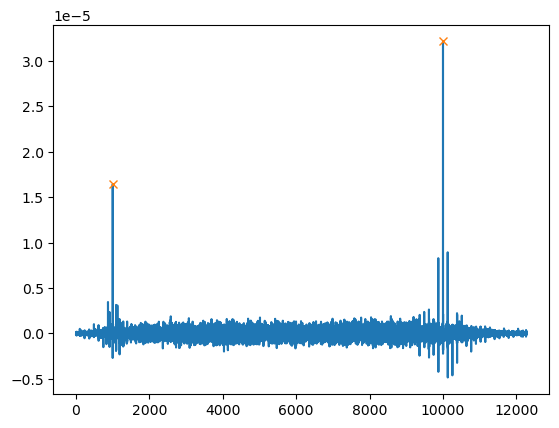

In [103]:
plt.plot(mf)
plt.plot(peaks, mf[peaks], "x")

In [431]:
peaks

array([ 1000, 10000])

In [432]:
peaks_data, _ = signal.find_peaks(map_1d/np.max(map_1d), height=0.5)
peaks_data

array([ 1000, 10000])

Checking intermediate products

/opt/anaconda3/envs/CHORD/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/CHORD/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


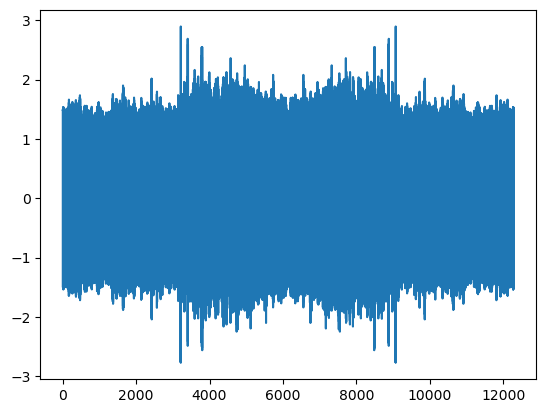

In [434]:
plt.plot(template_ft_white)

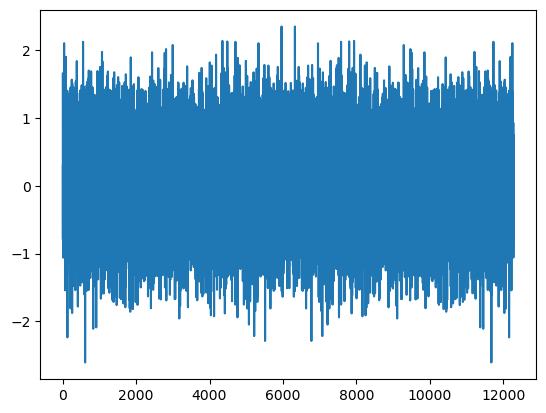

In [435]:
plt.plot(data_ft_white)

# Coming up with 2D map and template

In [438]:
x_b = np.linspace(-15, 15, 100)

In [439]:
from scipy import special

airy = special.jv(1, x_b*2*np.pi)/x_b/2/np.pi
airy[len(airy)//2] = airy[len(airy)//2-1]

airy_2d = np.outer(airy, airy)

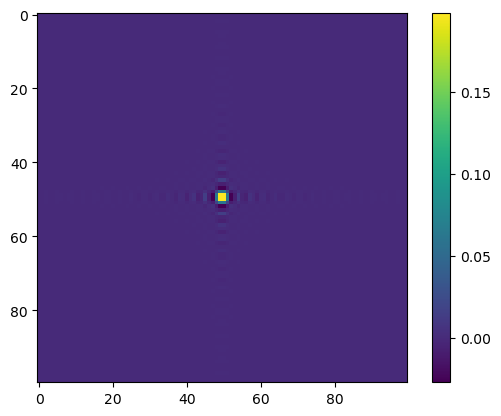

In [440]:
plt.imshow(airy_2d)
plt.colorbar()

In [441]:
map_2d = np.zeros((100,100))
map_2d[20,80] = 1
map_2d = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(map_2d)*np.fft.fft2(airy_2d))).real + 3e-3*np.random.randn(100,100)

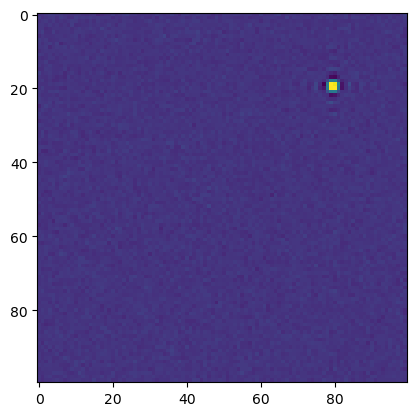

In [442]:
plt.imshow(map_2d)

# attempting 2D matched filter

In [443]:
win_temp = signal.windows.tukey(100)
win_2d = np.sqrt(np.outer(win_temp,win_temp))
ps_2d = np.abs(np.fft.fft2(map_2d * win_2d))**2
ps_smooth_2d = smooth_vector(ps_2d, Ninv_smoothing_sigma)
Ninv_2d = 1/ps_smooth_2d

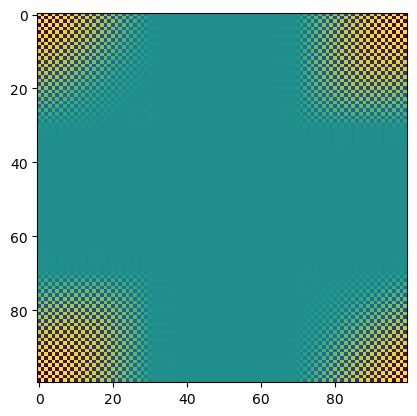

In [444]:
plt.imshow(np.fft.fft2(airy_2d).real)

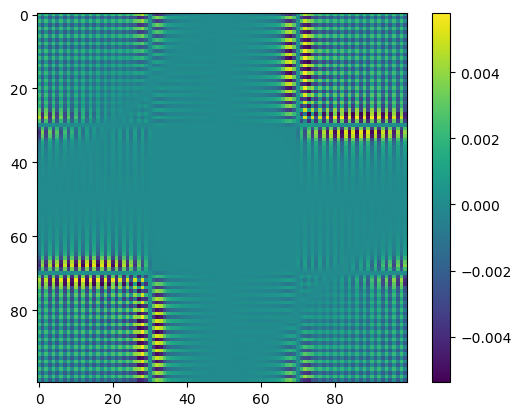

In [445]:
plt.imshow(np.fft.fft2(airy_2d*win_2d).real - np.fft.fft2(airy_2d).real)
plt.colorbar()

In [446]:
## Step 6: Preparing template for mf
template_ft = np.fft.fft2(airy_2d*win_2d)
template_ft_white = template_ft * np.sqrt(Ninv_2d)

## Step 6: Preparing data for mf
data_ft = np.fft.fft2(map_2d*win_2d)
data_ft_white = data_ft * np.sqrt(Ninv_2d)

## Step 7: Computing matched filter
rhs = np.real(np.fft.ifft2(data_ft_white * np.conj(template_ft_white)))
lhs = np.real(template_ft_white.T @ template_ft_white)
mf_2d = rhs / lhs

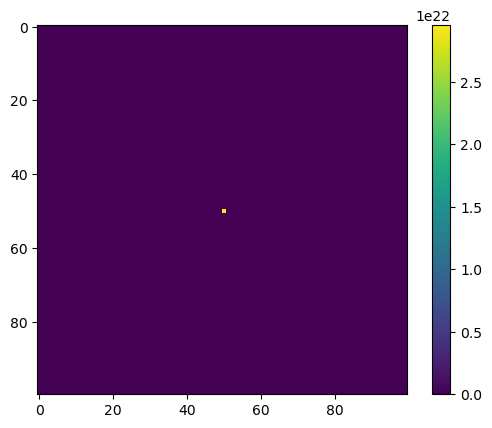

In [447]:
plt.imshow(mf_2d)
plt.colorbar()

In [448]:
idx = np.unravel_index(np.argmax(mf_2d), mf_2d.shape)
idx

(50, 50)

In [449]:
idx = np.unravel_index(np.argmax(map_2d), map_2d.shape)
idx

(20, 80)

In [450]:
idx = np.unravel_index(np.argmax(airy_2d), airy_2d.shape)
idx

(49, 49)

In [451]:
tetsing = np.fft.fftshift(np.fft.ifft2(data_ft_white*template_ft_white)).real
div = (template_ft_white.T @ template_ft_white).real

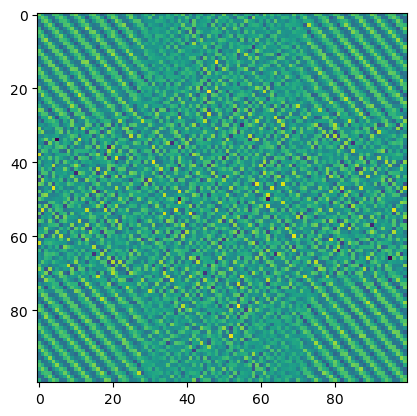

In [452]:
plt.imshow(data_ft_white.real)

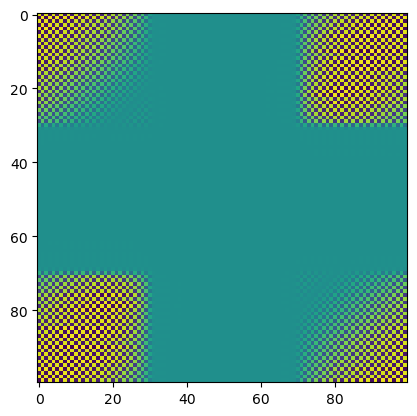

In [453]:
plt.imshow(template_ft_white.real)

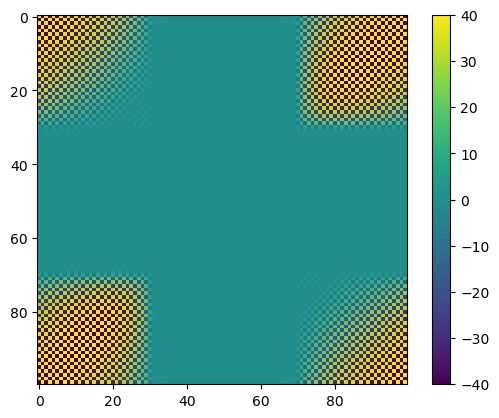

In [454]:
plt.imshow(div)
plt.colorbar()

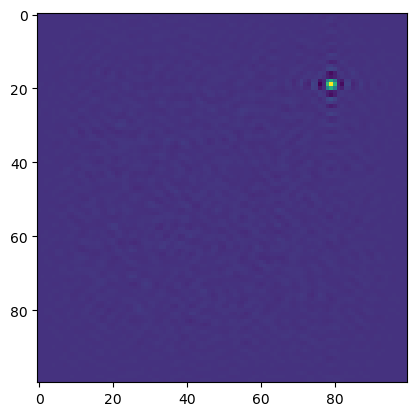

In [455]:
plt.imshow(tetsing)

# trying naive version

In [456]:
data_ft = np.fft.fft2(map_2d*win_2d)
template_ft = np.fft.fft2(airy_2d*win_2d)
mf_out = np.real(np.fft.ifft2(data_ft*template_ft))

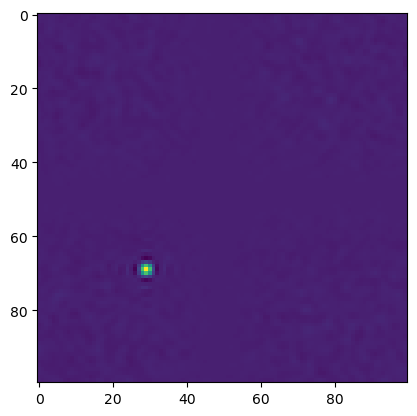

In [457]:
plt.imshow(mf_out.real)

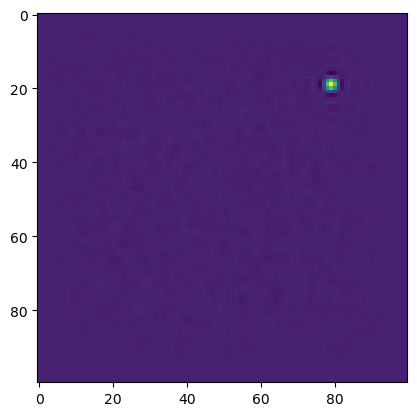

In [458]:
plt.imshow(np.fft.fftshift(mf_out).real)

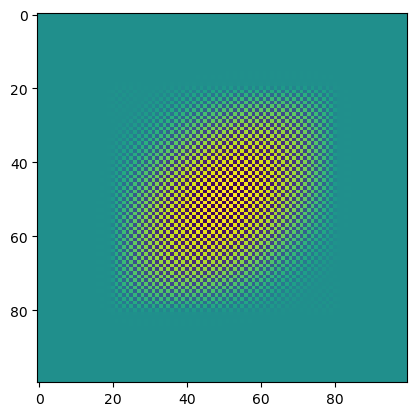

In [459]:
div = template_ft.T @ template_ft
plt.imshow(np.fft.fftshift(div).real)

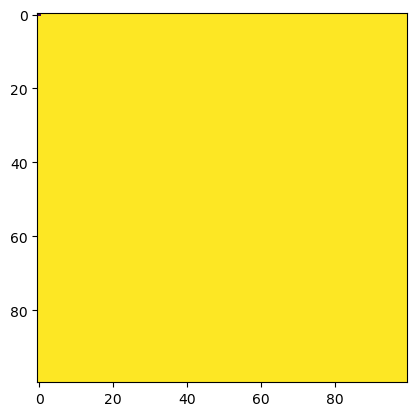

In [460]:
plt.imshow(np.fft.fftshift(mf_out).real/np.fft.fftshift(div).real)

In [461]:
idx = np.unravel_index(np.argmax(mf_out), mf_out.shape)
idx

(69, 29)

In [462]:
idx = np.unravel_index(np.argmax(map_2d), mf_out.shape)
idx

(20, 80)

# turning into 2D map for comparison

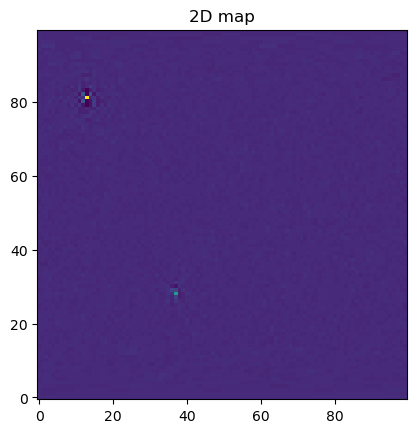

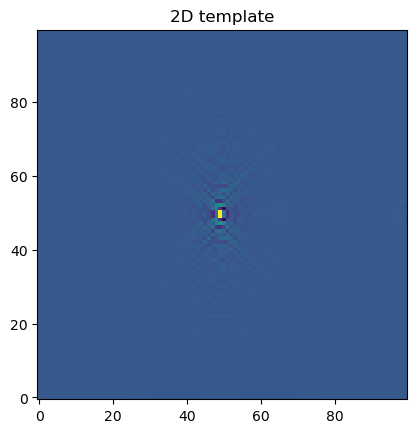

In [463]:
from functools import partial

n_pixels = 100

# Get the cutout via a cartesian projection
lonra = [0, 360]
latra = [-90, 90]

proj = hp.projector.CartesianProj(
    lonra=lonra, latra=latra,
    coord='G',
    xsize=n_pixels, ysize=n_pixels)

map_2d = proj.projmap(map_1d, vec2pix_func=partial(hp.vec2pix, 32))
template_2d = proj.projmap(template_1d, vec2pix_func=partial(hp.vec2pix, 32))

# Plot the cutout
plt.imshow(map_2d, origin='lower', interpolation='nearest')
plt.title('2D map')
plt.show()

plt.imshow(template_2d, origin='lower', interpolation='nearest')
plt.title('2D template')
plt.show()


# 2D matched filter

In [464]:
win_temp = signal.windows.tukey(n_pixels)
win_2d = np.sqrt(np.outer(win_temp,win_temp))
ps_2d = np.abs(np.fft.fft2(map_2d * win_2d))**2
ps_smooth_2d = smooth_vector(ps_2d, Ninv_smoothing_sigma)
Ninv_2d = 1/ps_smooth_2d

In [470]:
## Step 6: Preparing template for mf
template_ft = np.fft.fft2(template_2d*win_2d)
template_ft_white = template_ft * np.sqrt(Ninv_2d)

## Step 6: Preparing data for mf
data_ft = np.fft.fft2(map_2d*win_2d)
data_ft_white = data_ft * np.sqrt(Ninv_2d)

## Step 7: Computing matched filter
rhs = np.real(np.fft.ifft2(data_ft_white * np.conj(template_ft_white)))
lhs = np.real(template_ft_white.T @ template_ft_white)
mf_2d = rhs / lhs

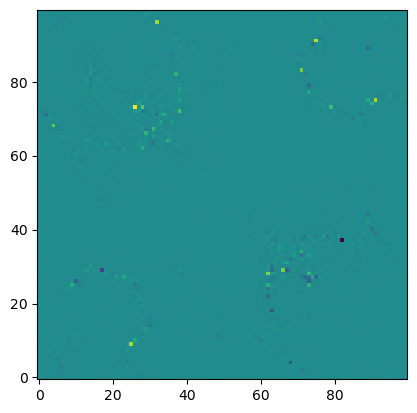

In [473]:
plt.imshow(np.fft.fftshift(mf_2d), origin='lower', interpolation='nearest')
plt.show()

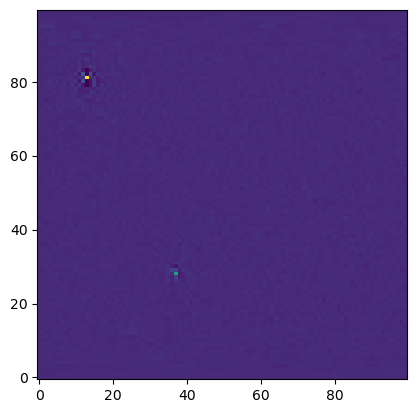

In [472]:
plt.imshow(map_2d, origin='lower', interpolation='nearest')

# Trying again

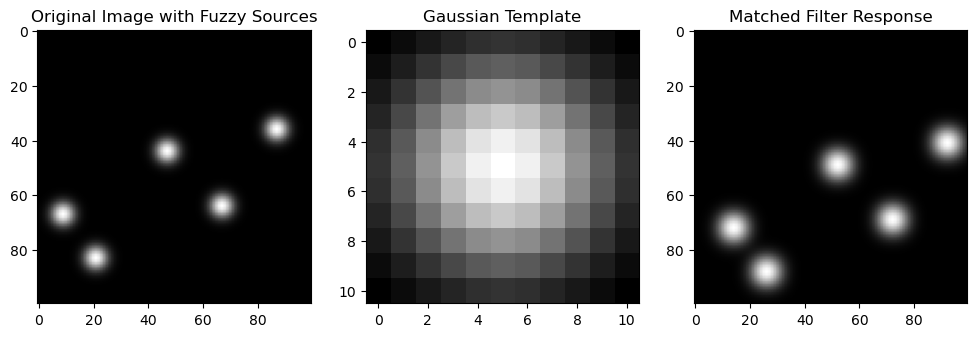

In [7]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

def create_fuzzy_sources(shape, num_sources, std_dev):
    """
    Creates an image with a few fuzzy sources.
    
    Parameters:
    - shape: tuple, the shape of the image (height, width).
    - num_sources: int, the number of fuzzy sources (stars).
    - std_dev: float, the standard deviation of the Gaussian sources.
    
    Returns:
    - image: 2D array representing the image with fuzzy sources.
    """
    image = np.zeros(shape)
    np.random.seed(0)  # For reproducibility
    
    for _ in range(num_sources):
        x, y = np.random.randint(0, shape[0]), np.random.randint(0, shape[1])
        image[x, y] = 1  # Set the source location
    
    # Apply Gaussian filter to create fuzzy sources
    image = scipy.ndimage.gaussian_filter(image, sigma=std_dev)
    
    return image

def create_gaussian_template(size, std_dev):
    """
    Creates a Gaussian template.
    
    Parameters:
    - size: int, the size of the template (size x size).
    - std_dev: float, the standard deviation of the Gaussian template.
    
    Returns:
    - template: 2D array representing the Gaussian template.
    """
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    template = np.exp(-(xx**2 + yy**2) / (2 * std_dev**2))
    
    return template

def fft_convolve2d(image, template):
    """
    Applies a 2D convolution using FFT.
    
    Parameters:
    - image: 2D array representing the input image.
    - template: 2D array representing the template to match.
    
    Returns:
    - result: 2D array representing the convolution result.
    """
    # Determine the size for zero-padding
    shape = (image.shape[0] + template.shape[0] - 1, image.shape[1] + template.shape[1] - 1)
    
    # Perform FFT on both image and template
    fft_image = np.fft.fft2(image, shape)
    fft_template = np.fft.fft2(template, shape)
    
    # Element-wise multiplication in the frequency domain
    fft_result = fft_image * fft_template
    
    # Inverse FFT to get the convolution result
    result = np.fft.ifft2(fft_result)
    
    # Crop the result to the original image size
    result = np.real(result[:image.shape[0], :image.shape[1]])
    
    return result


# Create an image with fuzzy sources
image_shape = (100, 100)
num_sources = 5
source_std_dev = 3
image = create_fuzzy_sources(image_shape, num_sources, source_std_dev)

# Create a Gaussian template
template_size = 11
template_std_dev = 3
template = create_gaussian_template(template_size, template_std_dev)

# Apply FFT-based matched filter
result = fft_convolve2d(image, template)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image with Fuzzy Sources")
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Gaussian Template")
plt.imshow(template, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Matched Filter Response")
plt.imshow(result, cmap='gray')

plt.show()

In [46]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

def create_fuzzy_sources(shape, num_sources, std_dev):
    """
    Creates an image with a few fuzzy sources.
    
    Parameters:
    - shape: tuple, the shape of the image (height, width).
    - num_sources: int, the number of fuzzy sources (stars).
    - std_dev: float, the standard deviation of the Gaussian sources.
    
    Returns:
    - image: 2D array representing the image with fuzzy sources.
    """
    image = np.zeros(shape)
    np.random.seed(0)  # For reproducibility
    
    for _ in range(num_sources):
        x, y = np.random.randint(0, shape[0]), np.random.randint(0, shape[1])
        image[x, y] = 1  # Set the source location
    
    # Apply Gaussian filter to create fuzzy sources
    image = scipy.ndimage.gaussian_filter(image, sigma=std_dev)
    
    return image

def create_gaussian_template(size, std_dev):
    """
    Creates a Gaussian template.
    
    Parameters:
    - size: int, the size of the template (size x size).
    - std_dev: float, the standard deviation of the Gaussian template.
    
    Returns:
    - template: 2D array representing the Gaussian template.
    """
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    template = np.exp(-(xx**2 + yy**2) / (2 * std_dev**2))
    
    return template

def add_noise(image, noise_std_dev):
    """
    Adds Gaussian noise to an image.
    
    Parameters:
    - image: 2D array representing the input image.
    - noise_std_dev: float, standard deviation of the Gaussian noise.
    
    Returns:
    - noisy_image: 2D array representing the noisy image.
    - noise: 2D array representing the added noise.
    """
    noise = np.random.normal(0, noise_std_dev, image.shape)
    noisy_image = image + noise
    
    return noisy_image, noise

def compute_power_spectrum(image, shape):
    """
    Computes the power spectrum of the image with zero-padding.
    
    Parameters:
    - image: 2D array representing the input image.
    - shape: tuple, the shape for zero-padding.
    
    Returns:
    - power_spectrum: 2D array representing the power spectrum of the noise.
    """
    image_fft = np.fft.fft2(image, shape)
    power_spectrum = np.abs(image_fft)**2
    
    return np.fft.fftshift(power_spectrum)

def fft_matched_filter_with_noise(image, template, N_inv):
    """
    Applies a 2D matched filter using FFT and incorporates noise weighting.
    
    Parameters:
    - image: 2D array representing the input image.
    - template: 2D array representing the template to match.
    - N_inv: 2D array representing the inverse noise power spectrum.
    
    Returns:
    - result: 2D array representing the filter response.
    """
    # Determine the size for zero-padding
    shape = (image.shape[0] + template.shape[0] - 1, image.shape[1] + template.shape[1] - 1)
    
    # Perform FFT on both image and template
    fft_image = np.fft.fft2(image, shape)
    fft_template = np.fft.fft2(template, shape)
    
    # adding extra steps
    rhs_fft = fft_image * np.conj(fft_template)
    lhs_fft = fft_template.T @ fft_template

    rhs = np.fft.ifft2(rhs_fft)
    lhs = np.fft.ifft2(lhs_fft)

    test_result = rhs / lhs

    # Perform matched filtering with noise weighting
    fft_result = fft_image * fft_template * N_inv
    
    # Inverse FFT to get the convolution result
    result = np.fft.ifft2(fft_result)
    
    # Crop the result to the original image size
    result = np.real(result[:image.shape[0], :image.shape[1]])
    
    return result, np.real(rhs), np.real(lhs)
    #return np.real(test_result[:image.shape[0], :image.shape[1]]), np.real(rhs), np.real(lhs)


